# RealNVP

Real-Valued Non-Volume Preserving Transformation- is the flow-based deep neural network, which is a tytpe of a probabilistic generative models that uses a sequence of invertible transformations to model complex data distributions. 

Some key characteristics are:
- Use bijective(invertible) functions, allowing efficien computation of forward of data to latent space and reverse transformation to data space. This means no information will be lost during the recovering from the latent space
- Use of Jacobian Determinant which is essential for handle dimensionality changes without losing data.

Applied areas:
- Density Estimation and Anomaly Detection. The exact likelihood computation makes it easier to identify anomalies
- Image and Vide generation
- Reversible data compression
- Data augmentation for cases when there are lack of original data
- Bayesian Inference and Probabillists modeling when uncertanty needs to be incorporated  
etc.

## INITIALIZATION

### Imports

In [14]:
from sklearn import datasets
from tensorflow.keras import (
    layers,
    regularizers,
    models,
    metrics,
    optimizers,
    callbacks,
    datasets
)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf
import datetime
import tensorflow_datasets as tfds

### Functions

In [11]:
def display_img(images, n=10, fig_size=(20, 3), c_map='gray_r', as_type='float32', save_to=None):
    if save_to is not None:
        oFull_path = Path(save_to)
        
        oFull_path.parent.mkdir(parents=True, exist_ok=True)

    
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=fig_size)

    for i in range(n):
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')

    # Сохранение изображения
    if save_to:
        plt.savefig(save_to)

    plt.show()

def display_mnist_imgs(images, labels, n=5, show_random=False):
    '''
    Display images from MNIST dataset
    Args:
        images (ndarray): MNIST images
        labesls (ndarray): MNIST labels
        n (int): Number of images to display
        show_random (bool): Select images randonly or not

    Returns:
        Generates images from MNIST dataset in accrordance with given parameters
    '''
    
    if show_random:
        img_idx= np.random.choice(images.shape[0], n, replace=False)
    else:
        img_idx= range(0, n)

    plt.figure(figsize=(10,10))

    for i, idx in enumerate(img_idx):
        plt.subplot(2,n,i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')
    plt.show()

# Discretize function to convert [0, 1] range to [0, 255] (integers)
def discretize(sample):
    return tf.cast(sample * 255, tf.int32)

def show_imgs(imgs, title=None, row_size=4):
    # Convert images to NumPy array if they are in TensorFlow tensor format
    if isinstance(imgs, tf.Tensor):
        imgs = imgs.numpy()
    
    num_imgs = imgs.shape[0]
    is_int = imgs.dtype == np.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    
    # Normalize pixel values if they are integers
    if is_int:
        imgs = np.clip(imgs, 0, 255)
        imgs = imgs.astype(np.uint8)
    else:
        imgs = np.clip(imgs, 0, 1)

    # Arrange images in a grid
    grid_img = []
    for i in range(ncol):
        row_imgs = imgs[i * nrow:(i + 1) * nrow]
        if len(row_imgs) < nrow:
            # Pad row with blank images if necessary
            padding = nrow - len(row_imgs)
            pad_img = np.zeros_like(row_imgs[0])
            row_imgs = np.concatenate([row_imgs, np.array([pad_img] * padding)])
        grid_img.append(np.concatenate(row_imgs, axis=1))
    
    grid_img = np.concatenate(grid_img, axis=0)

    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(grid_img, interpolation='nearest', cmap='gray' if is_int else None)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

## KEARS MNIST

### Prepare Datasets

In [16]:
(ds_train, ds_test), ds_info= tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [17]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [18]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### BUILD RealNVP

In [63]:
def Coupling_MNIST(input_shape, coupling_dim, reg):
   
    input_layer = layers.Input(shape=(input_shape))

    # Sсale component architecture
    # firtst 4 layers have relu activation which helps to learn non-linearity, as well as squize and scale data flow
    # tanh activation on last layer for stability purposes
    s_layer_1= layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same'
    )(input_layer)

    s_layer_2=layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same'
    )(s_layer_1)

    s_layer_3= layers.Flatten()(s_layer_2)
    s_layer_4= layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer= regularizers.l2(reg)
    )(s_layer_3)

    # We use a tanh activation multiplied by a learned scale parameter. This is presumably to mitigate 
    # the effect of using exp(s) to scale the variables. Directly using the outputs of a neural network could cause 
    # big swings in s leading to blowing up exp(s). 
    # To same point as above we also add a small L2 regularization on s
    s_layer_output= layers.Dense(
        input_shape[0] * input_shape[1], 
        activation='tanh',
        kernel_regularizer= regularizers.l2(reg)
    )(s_layer_4)

    # Note the number of output vars are equal to input
    s_layer_output= layers.Reshape(
        (
            input_shape[0],
            input_shape[1]
        )
    )(s_layer_output)

    # Shift component architecture
    # relu activation uses for to learn non-linearity purposes
    # last layer uses linear activation as we need to shift our data flow with no restrictions
    t_layer_1= layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(reg)
    )(input_layer)

    t_layer_2= layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)

    t_layer_3= layers.Flatten()(t_layer_2)

    t_layer_4= layers.Dense(
        coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)

    t_layer_output= layers.Dense(
        input_shape[0] * input_shape[1],
        activation='linear',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layers_4)

    t_layer_output= layers.Reshape(
        (
            input_shape[0],
            input_shape[1]
        )
    )(t_layer_output)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])
    

In [ ]:
class RealNVP(models.Model):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()

        self.coupling_layers = coupling_layers
        # Configure a multivariate normal distribution with zero mean and unit variance.
        # This is used as the target distribution in the latent space, to which the model will map input data.
        self.distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])

        # Configure masks used to construct the coupling layers. Masks alternate between [0, 1] and [1, 0],
        # allowing some components to be transformed while others remain unchanged at each layer.
        self.masks = np.array([[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32")
        

        # Set up a metric to track the average loss during training.
        self.loss_tracker = metrics.Mean(name='loss')

        # Initialize the list of coupling layers with the given input dimension, layer width, and regularization.
        self.flows = [Coupling_MNIST(input_dim, coupling_dim, regularization) for i in range(coupling_layers)]

        self.input_dim=input_dim
       
       
    @property
    def metrics(self):
        return [self.loss_tracker]

   # This is X data which will be passed to the flow f(x)(i.e. Coupling) and z returned in the end
    def call(self, x, training=True):
        '''
        Forward pass function that computes the model's output and the log-determinant of the Jacobian.
        '''
      
        # Variable to accumulate the sum of log-determinants of the Jacobian, necessary for density estimation.
        log_det_inv = 0

        # Set the direction of flow: reverse during training (-1) to map data to the latent distribution,
        # and forward (1) during inference to sample from the latent space.
        direction = -1 if training else 1

        for i in range(self.flows)[::direction]:
            # Mask the data using the i-th mask to select components for transformation.
            x_masked = x * self.masks[i]
            
            # Reverse the mask to select the components that will remain unchanged.
            # The reversed_mask itself is a tensor that alternates between values of 0 and 1, 
            # meaning some parts of s and t will effectively be multiplied by 0, setting them to zero for specific components,
            # it used to control which parts of s and t are applied to x in each step.
            reversed_mask = 1 - self.masks[i]

            # Obtain the scale (s) and shift (t) factors from the i-th coupling layer.
            # These parameters apply a non-linear transformation to masked components.
            s, t = self.flows[i](x_masked)
           
            # Ensure only masked components are transformed by setting other components of s and t to zero.
            # Here, s *= reversed_mask and t *= reversed_mask serve to "zero out" certain elements in s and t 
            # for specific parts of the input, based on which components are masked at each layer.
            # This ensures that when we later apply the affine transformation x * exp(s) + t, 
            # it only affects the selected components and leaves the others unchanged.
            s *= reversed_mask
            t *= reversed_mask
           
            
            # Calculate the gate coefficient for adjusting transformation scaling direction.
            gate = (direction - 1) / 2
            
            # Update the data by applying an affine transformation, keeping part of x unchanged and transforming the rest.
            z = (reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) + x_masked)
            
            # Accumulate the log-determinant Jacobian, critical for computing probability densities.
            ldj += gate * tf.reduce_sum(s, axis=1)

        # return latent space z if trainig True, and recovered data if False
        return z, ldj

    def log_loss(self, x):
        '''
        Calculates the log-likelihood loss function.
        '''

        # Call method call via self. Transform input x to output y and compute the log-determinant of the Jacobian (logdet).
        y, ldj = self(x)
        # Compute log-likelihood in latent space by combining the log probability and log determinant.
        log_likelihood = self.distribution.log_prob(y) + ldj

        # Return the negative mean log-likelihood (for loss minimization).
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        # Record operations for automatic differentiation.
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)

        # Compute gradients and update the model's trainable variables.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update the tracked loss metric with the current loss value.
        self.loss_tracker.update_state(loss)

      
       
        return {'loss': self.loss_tracker.result()}

    def test_step(self, data):
        # Calculate and track the loss in evaluation mode.
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {'loss': self.loss_tracker.result()}


In [ ]:
class Dequantization()

In [ ]:
model = RealNVP(
    input_dim=(28, 28, 1),
    coupling_layers=8,  # Можно начать с 8 и потом увеличить
    coupling_dim=256,
    regularization=0.01
)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4))

In [64]:

tfd = tfp.distributions

class ImageFlow(tf.keras.Model):
    def __init__(self, flows, import_samples=8):
        """
        Arguments:
            flows - A list of flows (each a tf.keras.Layer) to be applied on images.
            import_samples - Number of importance samples for testing.
        """
        super(ImageFlow, self).__init__()
        self.flows = flows
        self.import_samples = import_samples
        self.prior = tfd.Normal(loc=0.0, scale=1.0)  # Prior distribution

    def encode(self, imgs):
        """
        Given a batch of images, return the latent representation z and ldj of transformations.
        """
        z = imgs
        ldj = tf.zeros([tf.shape(imgs)[0]])  # Initialize log-det-jacobian
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood.
        If return_ll is True, returns log-likelihood.
        Otherwise, returns bits per dimension (bpd).
        """
        z, ldj = self.encode(imgs)
        log_pz = tf.reduce_sum(self.prior.log_prob(z), axis=[1, 2, 3])  # Sum over all dimensions
        log_px = ldj + log_pz
        nll = -log_px
        # Bits per dimension calculation
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return tf.reduce_mean(bpd) if not return_ll else log_px

    def sample(self, img_shape, z_init=None):
        """
        Generate a batch of images by inverting the flows.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape)
        else:
            z = z_init
        ldj = tf.zeros([img_shape[0]])
        # Reverse the flows to transform z to x
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def call(self, imgs):
        # Forward function used to calculate likelihood during training
        return self._get_likelihood(imgs)

    def train_step(self, data):
        imgs, _ = data  # Unpack data (images, labels)
        with tf.GradientTape() as tape:
            bpd = self._get_likelihood(imgs)
        grads = tape.gradient(bpd, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(bpd)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        imgs, _ = data
        # Importance sampling
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(imgs, return_ll=True)
            samples.append(img_ll)
        img_ll = tf.stack(samples, axis=-1)
        img_ll = tf.reduce_logsumexp(img_ll, axis=-1) - np.log(self.import_samples)
        # Calculate bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        self.compiled_metrics.update_state(bpd)
        return {m.name: m.result() for m in self.metrics}


In [73]:
# Определяем слой Dequantization (предполагается, что он уже определен)
class Dequantization(tf.keras.layers.Layer):
    def __init__(self, alpha=1e-5, quants=256, **kwargs):
        super(Dequantization, self).__init__(**kwargs)
        self.alpha = alpha
        self.quants = quants

    def call(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * tf.reduce_prod(tf.shape(z)[1:])
            z = tf.clip_by_value(tf.floor(z), 0, self.quants - 1)
            z = tf.cast(z, tf.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        if not reverse:
            ldj += tf.reduce_sum(-z - 2 * tf.nn.softplus(-z), axis=[1, 2, 3])
            z = tf.sigmoid(z)
            ldj -= np.log(1 - self.alpha) * tf.reduce_prod(tf.shape(z)[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha
            ldj += np.log(1 - self.alpha) * tf.reduce_prod(tf.shape(z)[1:])
            ldj += tf.reduce_sum(-tf.math.log(z) - tf.math.log(1 - z), axis=[1, 2, 3])
            z = tf.math.log(z) - tf.math.log(1 - z)
        return z, ldj

    def dequant(self, z, ldj):
        # Преобразуем z в float32 и добавляем шум
        z = tf.cast(z, tf.float32)
        z = z + tf.random.uniform(tf.shape(z), minval=0, maxval=1, dtype=tf.float32)
        z = z / self.quants
        
        # Преобразуем результат tf.reduce_prod к float32 для согласованности типов
        ldj -= tf.cast(np.log(self.quants), tf.float32) * tf.cast(tf.reduce_prod(tf.shape(z)[1:]), tf.float32)
        return z, ldj

In [74]:
# Тестируем инвертируемость
def test_dequantization_invertibility():
    # Инициализируем случайное значение для согласованности результатов
    tf.random.set_seed(42)
    
    # Загрузка примера изображения (для теста можно использовать произвольное изображение из MNIST)
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    orig_img = tf.expand_dims(tf.cast(x_train[0], tf.float32), axis=0)  # (1, 28, 28)
    ldj = tf.zeros((1,), dtype=tf.float32)
    
    # Инициализация слоя деквантования
    dequant_module = Dequantization()
    
    # Прямое и обратное деквантование
    deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
    reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)
    
    # Проверка на несовпадающие значения
    diff_indices = tf.where(tf.not_equal(orig_img, reconst_img))
    if tf.size(diff_indices) != 0:
        print("Dequantization was not invertible.")
        for i in range(tf.shape(diff_indices)[0]):
            original_value = orig_img[0, diff_indices[i][1], diff_indices[i][2]].numpy()
            reconstructed_value = reconst_img[0, diff_indices[i][1], diff_indices[i][2]].numpy()
            print(f"Original value: {original_value}, Reconstructed value: {reconstructed_value}")
    else:
        print("Successfully inverted dequantization")

    # Поскольку точная инверсия не гарантируется из-за ограничений точности float
    # tf.debugging.assert_equal(orig_img, reconst_img)

# Запуск теста
test_dequantization_invertibility()

InvalidArgumentError: Exception encountered when calling Dequantization.call().

[1mcannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: [0m

Arguments received by Dequantization.call():
  • z=tf.Tensor(shape=(1, 28, 28), dtype=float32)
  • ldj=tf.Tensor(shape=(1,), dtype=float32)
  • reverse=False

In [75]:
import tensorflow as tf

class CouplingLayer(tf.keras.layers.Layer):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Args:
            network: A Keras model constituting the deep neural network for `s` and `t`.
                     Output shape should be twice the channel size as the input.
            mask: Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                  while 1 means the latent will be used as input to the network.
            c_in: Number of input channels.
        """
        super().__init__()
        self.network = network
        self.scaling_factor = tf.Variable(tf.zeros(c_in), trainable=True, dtype=tf.float32)
        self.mask = tf.constant(mask, dtype=tf.float32)  # Save mask as a constant tensor

    def call(self, z, ldj, reverse=False, orig_img=None):
        """
        Forward pass of the coupling layer.
        Args:
            z: Latent input to the flow.
            ldj: The current ldj of the previous flows. The ldj of this layer will be added to this tensor.
            reverse: If True, apply the inverse of the layer.
            orig_img (optional): Optional conditioning input, e.g., original image.
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(tf.concat([z_in, orig_img], axis=-1))

        # Split network output into scale (s) and shift (t) parts
        s, t = tf.split(nn_out, num_or_size_splits=2, axis=-1)

        # Stabilize scaling output
        s_fac = tf.reshape(tf.exp(self.scaling_factor), (1, -1, 1, 1))
        s = tf.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            z = (z + t) * tf.exp(s)
            ldj += tf.reduce_sum(s, axis=[1, 2, 3])
        else:
            z = (z * tf.exp(-s)) - t
            ldj -= tf.reduce_sum(s, axis=[1, 2, 3])

        return z, ldj


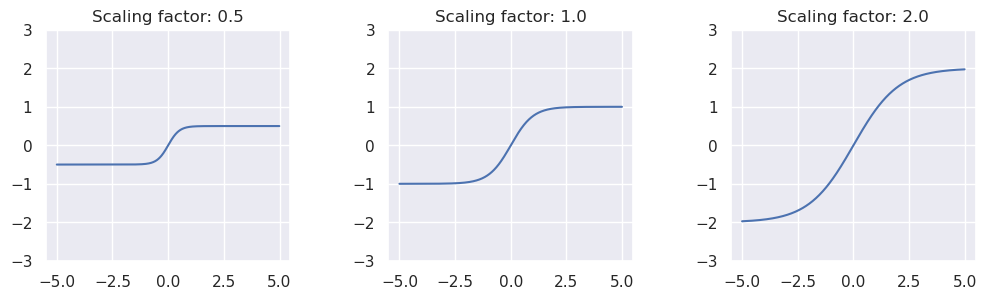

In [76]:
# Подготовим диапазон значений для x и список коэффициентов масштабирования
x = tf.range(-5.0, 5.0, 0.01)
scaling_factors = [0.5, 1.0, 2.0]

# Настроим визуализацию
sns.set()
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

# Построение графиков для каждого коэффициента масштабирования
for i, scale in enumerate(scaling_factors):
    y = tf.tanh(x / scale) * scale
    ax[i].plot(x.numpy(), y.numpy())  # Преобразуем тензоры в numpy для отображения
    ax[i].set_title("Scaling factor: " + str(scale))
    ax[i].set_ylim(-3, 3)

plt.subplots_adjust(wspace=0.4)
sns.reset_orig()
plt.show()

In [77]:
def create_checkerboard_mask(h, w, invert=False):
    # Создаем сетки индексов
    x = tf.range(h, dtype=tf.int32)
    y = tf.range(w, dtype=tf.int32)
    xx, yy = tf.meshgrid(x, y, indexing='ij')
    
    # Создаем маску с чередующимися значениями
    mask = tf.math.mod(xx + yy, 2)
    mask = tf.cast(mask, tf.float32)
    mask = tf.reshape(mask, (1, 1, h, w))  # Подгоняем под размер 4D тензора
    
    # Инвертируем маску при необходимости
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    # Создаем маску, где половина каналов заполнена единицами, а остальная часть нулями
    ones = tf.ones(c_in // 2, dtype=tf.float32)
    zeros = tf.zeros(c_in - c_in // 2, dtype=tf.float32)
    mask = tf.concat([ones, zeros], axis=0)
    mask = tf.reshape(mask, (1, c_in, 1, 1))  # Подгоняем под размер 4D тензора
    
    # Инвертируем маску при необходимости
    if invert:
        mask = 1 - mask
    return mask

In [82]:
import math

# Создаем маски с использованием уже адаптированных функций
checkerboard_mask = tf.tile(create_checkerboard_mask(h=8, w=8), [1, 2, 1, 1])
channel_mask = tf.tile(create_channel_mask(c_in=2), [1, 1, 8, 8])



# Визуализация масок
show_imgs(tf.transpose(checkerboard_mask, perm=[0, 1, 2, 3]), "Checkerboard mask")
show_imgs(tf.transpose(channel_mask, perm=[0, 1, 2, 3]), "Channel mask")

TypeError: Invalid shape (2, 8, 8) for image data

In [ ]:
class ConcatELU(layers.Layer):
    def call(self, x):
        return tf.concat([tf.nn.elu(x), tf.nn.elu(-x)], axis=-1)

class LayerNormChannels(layers.Layer):
    def __init__(self, c_in, eps=1e-5):
        super(LayerNormChannels, self).__init__()
        self.gamma = self.add_weight("gamma", shape=(1, c_in, 1, 1), initializer="ones")
        self.beta = self.add_weight("beta", shape=(1, c_in, 1, 1), initializer="zeros")
        self.eps = eps

    def call(self, x):
        mean = tf.reduce_mean(x, axis=1, keepdims=True)
        var = tf.reduce_variance(x, axis=1, keepdims=True)
        y = (x - mean) / tf.sqrt(var + self.eps)
        return y * self.gamma + self.beta

class GatedConv(layers.Layer):
    def __init__(self, c_in, c_hidden):
        super(GatedConv, self).__init__()
        self.net = tf.keras.Sequential([
            ConcatELU(),
            layers.Conv2D(c_hidden, kernel_size=3, padding='same'),
            ConcatELU(),
            layers.Conv2D(2 * c_in, kernel_size=1)
        ])

    def call(self, x):
        out = self.net(x)
        val, gate = tf.split(out, num_or_size_splits=2, axis=-1)
        return x + val * tf.sigmoid(gate)

class GatedConvNet(layers.Layer):
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        super(GatedConvNet, self).__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers_list = [
            layers.Conv2D(c_hidden, kernel_size=3, padding='same')
        ]
        for _ in range(num_layers):
            layers_list += [
                GatedConv(c_hidden, c_hidden),
                LayerNormChannels(c_hidden)
            ]
        layers_list += [
            ConcatELU(),
            layers.Conv2D(c_out, kernel_size=3, padding='same')
        ]
        
        self.nn = tf.keras.Sequential(layers_list)

    def call(self, x):
        return self.nn(x)

def create_simple_flow(use_vardeq=True):
    flow_layers = []

    if use_vardeq:
        vardeq_layers = [
            CouplingLayer(
                network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
                c_in=1
            ) for i in range(4)
        ]
        flow_layers.append(VariationalDequantization(var_flows=vardeq_layers))
    else:
        flow_layers.append(Dequantization())

    for i in range(8):
        flow_layers.append(
            CouplingLayer(
                network=GatedConvNet(c_in=1, c_hidden=32),
                mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
                c_in=1
            )
        )

    flow_model = ImageFlow(flow_layers)
    return flow_model

https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.make_moons.html
https://bjlkeng.io/posts/normalizing-flows-with-real-nvp/#implementation
https://ar5iv.labs.arxiv.org/html/1605.08803
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html